# Credit default
__Note on how to use this notebook:__ <br>
1) Save the notebook to disk. <br>
2) Save the [data set](https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls) to the same folder that this notebook was saved in. 

[Data description](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) <br>




# Ideas:
Model-function Keras, layers in for loop, layer number as  input.

In [1]:
import pandas as pd
import os
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

The following runs the data preperation that is used for all models.

We scale all features by Sci-Kit learn's standard scaler. The standard scalars subtracts the mean, so that the means of the standardized variables equal zero. Furthermore the standard scaler divides the feautres by their respective variances, so that the variances of the standardized features equals one.

In [2]:
# Reading file into data frame
cwd = os.getcwd()
filename = cwd + '/default of credit card clients.xls'
nanDict = {}
df = pd.read_excel(filename, header=1, skiprows=0, index_col=0, na_values=nanDict)

df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)

# Features and targets 
X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values

# Categorical variables to one-hot's
onehotencoder = OneHotEncoder(categorical_features = [3])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:] 

# Train-test split
trainingShare = 0.5 
XTrain, XTest, yTrain, yTest=train_test_split(X, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare)

# Input Scaling
sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

# One-hot's of the target vector
Y_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)

# Remove instances with zeros only for past bill statements or paid amounts
'''
df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0) &
                (df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)
'''
df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0)].index)

df = df.drop(df[(df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)

# Descriptive information
print('Number of empty elements in data: ', df.isnull().values.any())
print('Observations: ', df.shape[0])
print('Percentage defaults: ', df['defaultPaymentNextMonth'].astype(bool).sum(axis=0)/df.shape[0]*100)

Number of empty elements in data:  False
Observations:  28497
Percentage defaults:  21.31452433589501


This is not the same number of observations as in Yeh and Lien (2009). Yeh and Lien (2009) have 25 000 observations. However, we have the same number of observations as in Pyzhov and Pyzhov (2017), which is said to use the same dataset as Yeh and Lien (2009). 

The percentage of individuals with default is the same as in the Yeh and Lien (2009).


# Logistic regression
We apply Sci-Kit learn's logistic regression method for performing classification of default and non-defaulting customers. It is possible to use regularization for the logistic regression. Regularization has the potential to reduce overfitting. We will apply Sci-Kit learn's Grid search function for identifying the optimal regularization value. The optimal regularization parameter is determined by the accuracy score on test sets applying K-fold cross validation.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lmbdas=np.logspace(-5,7,13)
parameters = [{'C': 1./lmbdas}]
scoring = ['accuracy', 'roc_auc']
logReg = LogisticRegression()
gridSearch = GridSearchCV(logReg, parameters, cv=5, scoring=scoring, refit='roc_auc') 
# "refit" gives the metric used deciding best model. 
# See more http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
gridSearch.fit(XTrain, yTrain.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': array([1.e+05, 1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02,
       1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07])}],
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['accuracy', 'roc_auc'], verbose=0)

In [5]:
def gridSearchSummary(method, scoring):
    method = eval(method)
    if scoring == 'accuracy':
        mean = 'mean_test_score'
        sd = 'std_test_score'
    elif scoring == 'auc':
        mean = 'mean_test_roc_auc'
        sd = 'std_test_roc_auc'
    print("Best: %f using %s" % (method.best_score_, method.best_params_))
    means = method.cv_results_[mean]
    stds = method.cv_results_[sd]
    params = method.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [13]:
gridSearchSummary('gridSearch', 'auc')

Best: 0.721986 using {'C': 0.1}
0.721899 (0.008569) with: {'C': 99999.99999999999}
0.721899 (0.008570) with: {'C': 10000.0}
0.721899 (0.008569) with: {'C': 1000.0}
0.721900 (0.008571) with: {'C': 100.0}
0.721904 (0.008577) with: {'C': 10.0}
0.721957 (0.008616) with: {'C': 1.0}
0.721986 (0.008736) with: {'C': 0.1}
0.720995 (0.009247) with: {'C': 0.01}
0.713753 (0.009438) with: {'C': 0.001}
0.700559 (0.007399) with: {'C': 0.0001}
0.694676 (0.007575) with: {'C': 1e-05}
0.693815 (0.007703) with: {'C': 1e-06}
0.693734 (0.007723) with: {'C': 1e-07}


We see that in terms of accuracy it does not matter much what the regularization parameter value is. The optimal parameter, among the chosen parameter values, is one, but the difference in test score between the eight first regularization parameter values is practically non-existent.

Create a function for printing accuracy results, confusion matrices and storing of these results.

In [6]:
def createConfusionMatrix(method):
    confusionArray = np.zeros(6, dtype=object)
    method = eval(method)
    
    print('\n###################  Training  ###############')
    yPredTrain = method.predict(XTrain)
    yPredTrain = (yPredTrain > 0.5)
    cm = confusion_matrix(
        yTrain, yPredTrain) 
    cm = np.around(cm/cm.sum(axis=1)[:,None], 2)
    confusionArray[0] = cm
    print('\nTraining Confusion matrix: \n', cm)
    accScore = accuracy_score(yTrain, yPredTrain)
    confusionArray[1] = accScore
    print('\nTraining Accuracy score: \n', accScore)
    AUC = roc_auc_score(yTrain, yPredTrain)
    confusionArray[2] = AUC
    print('\nTrain AUC: \n', AUC)
    
    print('\n###################  Testing  ###############')
    yPred = method.predict(XTest)
    yPred = (yPred > 0.5)
    cm = confusion_matrix(
        yTest, yPred) 
    cm = np.around(cm/cm.sum(axis=1)[:,None], 2)
    confusionArray[3] = cm
    print('\nTest Confusion matrix: \n', cm)
    accScore = accuracy_score(yTest, yPred)
    confusionArray[4] = accScore
    print('\nTest Accuracy score: \n', accScore)
    AUC = roc_auc_score(yTest, yPred)
    confusionArray[5] = AUC
    print('\nTestAUC: \n', AUC)    
    
    return confusionArray

In [16]:
confusionArrayLogreg = createConfusionMatrix('gridSearch')


###################  Training  ###############

Training Confusion matrix: 
 [[0.97 0.03]
 [0.75 0.25]]

Training Accuracy score: 
 0.8118

Train AUC: 
 0.6104815638963756

###################  Testing  ###############

Test Confusion matrix: 
 [[0.97 0.03]
 [0.77 0.23]]

Test Accuracy score: 
 0.8072666666666667

TestAUC: 
 0.5998386456904166


The accurcies and AUC's on the testing set is higher the cooresponding best mean numbers on the validation sets from the K-fold cross validation. We see that only about $1/4$ of the defaults get correctly predicted.

## Keras NN
We will now perform classification by deep neural networks. Keras is used. 


### Grid search
We will apply Sci-Kit learn's grid search function in order to determine the optimal combination of hyperparameters.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV



def createModel(neurons =50, hiddenLayers = 2):
    model = tf.keras.Sequential()
    neuronsPerLayer = neurons // (hiddenLayers + 1)
    model.add(tf.keras.layers.Dense(neuronsPerLayer, activation='relu', input_dim=XTrain.shape[1]))
    for i in range(hiddenLayers):
        model.add(tf.keras.layers.Dense(neuronsPerLayer, activation='relu'))
    model.add(tf.keras.layers.Dense(Y_train_onehot.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=createModel, verbose=0)

neurons = [20, 50, 100, 200, 300, 400]# 500]
hiddenLayers = [1, 2, 3, 5]
batch_size = [5, 10, 32, 64]##, 40, 60, 80, 100]
parameterGrid = [{'neurons': neurons, 'hiddenLayers': hiddenLayers, 'batch_size': batch_size}]
folds = 3
#scoring = ['accuracy', 'roc_auc']
scoring = 'roc_auc'
#grid = GridSearchCV(estimator=model, cv=folds, param_grid=parameterGrid, n_jobs=-1)
#grid = GridSearchCV(estimator=model, cv=folds, param_grid=parameterGrid, n_jobs=-1, scoring=scoring, refit='roc_auc')
grid = GridSearchCV(estimator=model, cv=folds, param_grid=parameterGrid, n_jobs=-1, scoring=scoring)

epochs = 10
grid_result = grid.fit(XTrain, Y_train_onehot, epochs=epochs)

In [6]:
gridSearchSummary('grid_result', 'accuracy') # Note that it is AUC that is printed

Best: 0.761327 using {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 200}
0.752635 (0.003034) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 20}
0.759858 (0.004175) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 50}
0.758405 (0.001298) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 100}
0.761327 (0.003652) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 200}
0.759914 (0.005431) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 300}
0.759342 (0.003141) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 400}
0.738678 (0.018294) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 20}
0.756553 (0.004414) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 50}
0.760684 (0.004166) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 100}
0.760575 (0.006323) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 200}
0.758413 (0.006746) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 300}
0.760983 (0.004713) with: {'batch_size': 5, 'hiddenLayers': 2

We see that the best combination of the chosen number of hidden layers and neuron numbers is one hidden layer and two hundred neurons. 

A batch size of 10 is the best among the chosen batch sizes.

Next we apply the optimal combination of batch size and neuron number from the crossvalidation train a model on the full training set. The model based on the full training set will then be applied to measure the accuracy on predictions on the test set.  

### FItting the best model: early stopping
We see from the above that the validation accuracy declines for the highest number of neurons. The decline in validation accuracy is a sign of overfitting. In order to avoid overfitting we use a methods for "early stopping". Early stopping stops the simulations when the validation set performance has dropped a user given number of times in a row. In order for the model to be able to escape local minima, we allo the validation accuracy to drop a few times before breaking. 

In [13]:
hiddenLayers, neurons =  grid_result.best_params_['hiddenLayers'], grid_result.best_params_['neurons']
batch_size = 5

model = KerasClassifier(build_fn=createModel, verbose=0, neurons =neurons, hiddenLayers = hiddenLayers)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                             min_delta=0,
                                             patience=2, # argument represents the number of epochs before stopping once your loss starts to increase (stops improving)
                                             verbose=0, 
                                             mode='auto')]#,
                                             #restore_best_weights=True)] # Use best model
history = model.fit(XTrain,
                        Y_train_onehot,
                        epochs=15, 
                        batch_size=batch_size,
                        validation_data=[XTest, Y_test_onehot],
                        callbacks = callbacks)

print('Number of epochs before early stopping: ', len(history.history['loss']))

Number of epochs before early stopping:  6


Confusion matrices, accuracy scores and AUC-numbers:

In [14]:
confusionArrayNN = createConfusionMatrix('model')


###################  Training  ###############

Training Confusion matrix: 
 [[0.95 0.05]
 [0.65 0.35]]

Training Accuracy score: 
 0.8198

Train AUC: 
 0.6507076050747016

###################  Testing  ###############

Test Confusion matrix: 
 [[0.95 0.05]
 [0.64 0.36]]

Test Accuracy score: 
 0.8184666666666667

TestAUC: 
 0.6549347316881102


Only about a third of the defaulting customers are correctly predicted. However, the performance is considerablt better than for logistic regression, where only a fourth of the customers with default was correctly predicted.

Ok accuracy. Not impressing performance when it compes to predicting the defaults. Only a 3rd of the defaults in the test set is correctly predicted. <br>

Yeh and Lien (2009) get: <br>
Training accuracy: 0.81<br>
Training AUC: 0.55 <br>
Testing accuracy: 0.83<br>
Testing AUC: 0.54 <br>

We see that we get the accuracy the the same level as Yeh and Lien (2009), but the AUC is better. However, it is unclear wheteher it acutally is AUC Yeh and Lien (2009) applies, as they call it area ratio.<br>

Pyzhov and Pyzhov (2017) get about the same acuracy as we do, but higher AUCs.

# Principal component analyses
We will explore the effects of training the network with principcal components. For many of the networks we do not expect the introduction of principcal components to improve the performance considerably. The difference between training and testing accuracy is small for many of the networks, indicating that there is little overfitting. Maybe for the network setuos where there are larger deviations between training and testing accuracy, the networks with mutiple hidden layers, there can be gains from introducing principcal components. 

We use the principal components that explain 95 per cent of total variance.

In [31]:
from sklearn.decomposition import PCA

'''
pca = PCA(n_components = 4)
pca.fit_transform(X)
#pca.components_.T[:,0] # Displays component
pca.explained_variance_ratio_
'''

pca = PCA(n_components = 0.95)
Xreduced = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.84870179 0.04871288 0.02708606 0.01606241 0.0144179 ]
0.9549810379752075


In [44]:
trainingShare = 0.5 
XTrain, XTest, yTrain, yTest=train_test_split(Xreduced, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare)
Y_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu', input_dim=XTrain.shape[1]))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(Y_train_onehot.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta = 0,
                                             patience=5,
                                             verbose=0,
                                             mode='auto')]


history = model.fit(XTrain,
                    Y_train_onehot, 
                    epochs=100, 
                    batch_size=30,
                    validation_data=[XTest, Y_test_onehot],
                    callbacks = callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 50)                300       
_________________________________________________________________
dense_50 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_51 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_52 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_53 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_54 (Dense)             (None, 2)                 102       
Total params: 10,602
Trainable params: 10,602
Non-trainable params: 0
_________________________________________________________________
None
T

We see that both training and testing accuracy is reduced when using Principal components as predictors instead of all of the original features. However, we also observe that the difference between training and validation accuracy is smaller when using principal components as predictors instead of all the features from the original data set.

## Kernel PCA
We will try Sci-Kit learn's kernel PCA method. Kernel PCA, kPca, is a PCA-method that allows for non-linearity. <mark> More about this!
    


In [60]:
from sklearn.decomposition import KernelPCA, TruncatedSVD
kPCA = KernelPCA(n_components=2, kernel='rbf', gamma=10) #0.04
#kPCA = TruncatedSVD(n_components=5, algorithm='arpack')
X_reduced = kPCA.fit_transform(X)
print(kPCA.explained_variance_ratio_)
print(np.sum(kPCA.explained_variance_ratio_))

MemoryError: 

kPCA did not work. It gave memory error.

# Support Vector Machines (SVM)
We will now apply the SVM classifier to make the classification. We start by running the standard SVM estimator, and then we try alternative methods that potentially increase accuracy in the presence of non-linearity in the data. By "non-linearity" we mean that the labels cannot be separated by a linear classification plane (line in 2D, 2D plane in 3D, hyperplane for higher dimensions than 3).

In [38]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


parameters = [{'C':np.logspace(-3,3,7)}]

svmNormal = LinearSVC(loss='hinge')

folds = 5
scoring = ['accuracy', 'roc_auc']

gridSearchSVMNormal = GridSearchCV(svmNormal, cv = folds, param_grid=parameters, scoring=scoring, refit='roc_auc')
SVMNormalCVResult = gridSearchSVMNormal.fit(XTrain, yTrain.ravel())

In [39]:
gridSearchSummary('SVMNormalCVResult', 'auc')

Best: 0.702691 using {'C': 0.1}
0.695115 (0.010884) with: {'C': 0.001}
0.697332 (0.018909) with: {'C': 0.01}
0.702691 (0.012212) with: {'C': 0.1}
0.698084 (0.012269) with: {'C': 1.0}
0.695827 (0.011824) with: {'C': 10.0}
0.591004 (0.059036) with: {'C': 100.0}
0.588038 (0.067428) with: {'C': 1000.0}


In [40]:
confusionArraySVMNormal = createConfusionMatrix('SVMNormalCVResult')


###################  Training  ###############

Training Confusion matrix: 
 [[0.97 0.03]
 [0.75 0.25]]

Training Accuracy score: 
 0.8108666666666666

Train AUC: 
 0.6094530879526134

###################  Testing  ###############

Test Confusion matrix: 
 [[0.97 0.03]
 [0.76 0.24]]

Test Accuracy score: 
 0.8081333333333334

TestAUC: 
 0.6032200030258787


For linear SVM the accuracies look very similar to the accuracies from logistic regression and neural networks. About a fourth of the customers with problem loans is predicted correctly with standard SVM. 

SVM stands out from the other mentioned methods in that the testing accuracy and AUC is a little higher than the training accuracy, which is unusual.

### Polynomial SVM
Increasing the complexity by introducing polynomial variables may increase the quality of the separation. We will not perform an polynomial SVM-estimation where we use second degree polynomials.

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(XTrain, yTrain)

/home/k/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [59]:
confusionArraySVMPoly = createConfusionMatrix('polynomial_svm_clf')


###################  Training  ###############

Training Confusion matrix: 
 [[0.98 0.02]
 [0.91 0.09]]

Training Accuracy score: 
 0.7817333333333333

Train AUC: 
 0.5359900246935011

###################  Testing  ###############

Test Confusion matrix: 
 [[0.98 0.02]
 [0.91 0.09]]

Test Accuracy score: 
 0.7837333333333333

TestAUC: 
 0.5353007275053306


The resuls with the 2nd degree polynomial are worse than with the normal SVM. Only a fourth of the customers with defauls is correctly predicted. Higher degree polynomial might work better. 
### SVM: Polynomial kernel
The computational cost quickly becomes large for higher degree polynomials. 

A remedy is to use the so-called Kernel trick to effectively apply higher degree polynomials. With the kernel-trick we get higher degree polynomials without the extra computational cost!

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svmPolynomialKernel = SVC(kernel='poly')
parameters = [{'degree': np.array((2,3)), 'C': [1.0]},
              {'C':np.logspace(-1,1,3), 'degree': [3]}]
scoring = ['accuracy', 'roc_auc']
folds = 5
smvPolyKernelGridSearch = GridSearchCV(svmPolynomialKernel, cv = folds, param_grid=parameters, scoring=scoring,
                                       refit='roc_auc')
smvPolyKernelGridSearchResult = smvPolyKernelGridSearch.fit(XTrain, yTrain.ravel())

In [20]:
gridSearchSummary('smvPolyKernelGridSearchResult', 'auc')

Best: 0.695678 using {'C': 1.0, 'degree': 3}
0.682577 (0.008191) with: {'C': 1.0, 'degree': 2}
0.695678 (0.013066) with: {'C': 1.0, 'degree': 3}
0.694016 (0.012264) with: {'C': 0.1, 'degree': 3}
0.695678 (0.013066) with: {'C': 1.0, 'degree': 3}
0.692909 (0.015770) with: {'C': 10.0, 'degree': 3}


Three degrees works better than ten degrees. The AUC is higher for three degrees than for ten degrees.

In [22]:
smvPolyKernelGridSearchResult.cv_results_

/home/k/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/k/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/k/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/k/.local/lib/python3.6/site-packages/skl

{'mean_fit_time': array([ 7.53603115,  8.95945077,  5.82700062,  8.97353044, 26.62665639]),
 'std_fit_time': array([0.36869547, 0.75958885, 0.24694452, 0.7656885 , 2.03865925]),
 'mean_score_time': array([0.95948038, 0.95194483, 0.96077495, 0.94495735, 0.9262002 ]),
 'std_score_time': array([0.00898825, 0.00857229, 0.0025406 , 0.00466272, 0.00522582]),
 'param_C': masked_array(data=[1.0, 1.0, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_degree': masked_array(data=[2, 3, 3, 3, 3],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1.0, 'degree': 2},
  {'C': 1.0, 'degree': 3},
  {'C': 0.1, 'degree': 3},
  {'C': 1.0, 'degree': 3},
  {'C': 10.0, 'degree': 3}],
 'split0_test_accuracy': array([0.78266667, 0.8       , 0.78833333, 0.8       , 0.80266667]),
 'split1_test_accuracy': array([0.78033333, 0.79766667, 0.79066667, 0.79766667

In [21]:
confusionArraySvmKernel = createConfusionMatrix('smvPolyKernelGridSearchResult')


###################  Training  ###############

Training Confusion matrix: 
 [[0.98 0.02]
 [0.76 0.24]]

Training Accuracy score: 
 0.8162

Train AUC: 
 0.6110393369497519

###################  Testing  ###############

Test Confusion matrix: 
 [[0.97 0.03]
 [0.78 0.22]]

Test Accuracy score: 
 0.8040666666666667

TestAUC: 
 0.5960181699035462


There was a gain increasing the degree from two, which we used with standard polynomial SVM, to three, which was the best degree found with polynomial kernel. The result is close to the result for standard SVM.

### SVM: Gaussian RBF Kernel
Another kernel method is the so-called Gaussian Radial Basis Function (RBF) method. Following Geron (2017) p. 153, the following transformation is used $$\phi_\gamma (\hat{x}, l) = \exp(-\gamma ||\hat{x} - l||^2), $$

where $l$ is the position of so-called landmarks. One often applies landmarks for every instancein the data set. This increases the number of features from the original feature number to the number of instances. The new variables represents a higher dimensional space compared to the original feature space, and the chance that the new features are linearly separable is increased. 

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = [{'gamma': np.logspace(-1,2,4), 'C': np.logspace(-1,1,3)}]
#parameters = [{'gamma': np.array((.1, 1)), 'C': np.array((.001, 1000))}]
#parameters = [{'gamma': np.array((.1, 1))}]

folds = 5
svmKernel = SVC(kernel='rbf')
scoring = ['accuracy', 'roc_auc']
svmKernelGridSearch = GridSearchCV(svmKernel, cv = folds, param_grid=parameters, scoring=scoring, refit='roc_auc')
svmKernelGridSearchResult = svmKernelGridSearch.fit(XTrain, yTrain.ravel())

In [32]:
#svmKernelGridSearchResult.cv_results_

In [7]:
gridSearchSummary('svmKernelGridSearchResult', 'auc')

Best: 0.709665 using {'C': 0.1, 'gamma': 0.1}
0.709665 (0.003858) with: {'C': 0.1, 'gamma': 0.1}
0.674762 (0.005201) with: {'C': 0.1, 'gamma': 1.0}
0.616270 (0.007552) with: {'C': 0.1, 'gamma': 10.0}
0.555003 (0.008345) with: {'C': 0.1, 'gamma': 100.0}
0.708395 (0.005685) with: {'C': 1.0, 'gamma': 0.1}
0.672249 (0.005904) with: {'C': 1.0, 'gamma': 1.0}
0.617239 (0.007812) with: {'C': 1.0, 'gamma': 10.0}
0.556863 (0.008124) with: {'C': 1.0, 'gamma': 100.0}
0.694284 (0.012556) with: {'C': 10.0, 'gamma': 0.1}
0.648543 (0.008121) with: {'C': 10.0, 'gamma': 1.0}
0.614746 (0.011279) with: {'C': 10.0, 'gamma': 10.0}
0.558185 (0.007859) with: {'C': 10.0, 'gamma': 100.0}


In [10]:
confusionArrayRBFKernel = createConfusionMatrix('svmKernelGridSearchResult')


###################  Training  ###############

Training Confusion matrix: 
 [[0.96 0.04]
 [0.7  0.3 ]]

Training Accuracy score: 
 0.8156666666666667

Train AUC: 
 0.6316046322708714

###################  Testing  ###############

Test Confusion matrix: 
 [[0.96 0.04]
 [0.72 0.28]]

Test Accuracy score: 
 0.8111333333333334

TestAUC: 
 0.6218802874564073


Test AUC is higer than with standard SVM and polynomial SVM. For the Gaussian kernel estimator, 28 per cent of the defaulted customers are predicted correctly.

# Comparison of the estimators

In [46]:
confusionArrayRBFKernel[3][1,1]


0.28

0.28

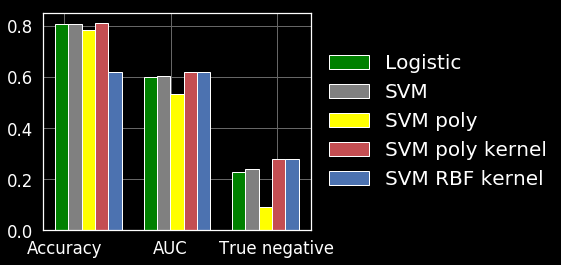

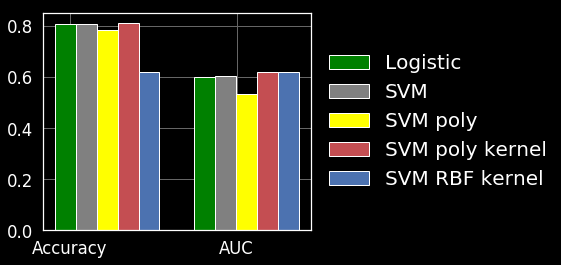

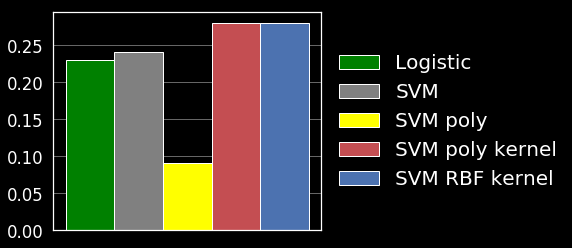

In [69]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5, 
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})
#seaborn.set(style="ticks", context="talk")
plt.style.use("dark_background")
seaborn.set_style({'grid.color': '.4'})

confusionArrayLogreg
#confusionArrayNN
confusionArraySVMNormal
confusionArraySVMPoly
confusionArraySvmKernel
confusionArrayRBFKernel

fig, ax = plt.subplots()
numerOfVariables = 3
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayLogreg[4], confusionArrayLogreg[5], 
                                        confusionArrayLogreg[3][1,1]]), width, color='green')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArraySVMNormal[4], confusionArraySVMNormal[5],
                                       confusionArraySVMNormal[3][1,1]]), width, color='grey')
rects4 = ax.bar(ind+3*width, np.asarray([confusionArraySVMPoly[4], confusionArraySVMPoly[5],
                                       confusionArraySVMPoly[3][1,1]]), width, color='yellow')
rects5 = ax.bar(ind+4*width, np.asarray([confusionArraySvmKernel[4], confusionArraySvmKernel[5],
                                        confusionArraySvmKernel[3][1,1]]), width, color='r')
rects6 = ax.bar(ind+5*width, np.asarray([confusionArrayRBFKernel[5], confusionArrayRBFKernel[5],
                                        confusionArrayRBFKernel[3][1,1]]), width, color='b')
#rects5 = ax2.bar(ind+4*width, np.asarray([beta0[4], beta1[4], beta2[4]]), width, color='pink')
fontSize = 20
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*1.2 )#/ 2)
variableNames = ['Accuracy', 'AUC', 'True negative']
ax.set_xticklabels(variableNames)
legends = ['Logistic', 'SVM', 'SVM poly', 'SVM poly kernel', 'SVM RBF kernel']
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)


fig, ax = plt.subplots()
numerOfVariables = 2
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayLogreg[4], confusionArrayLogreg[5]]), width, color='green')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArraySVMNormal[4], confusionArraySVMNormal[5]]), width, color='grey')
rects4 = ax.bar(ind+3*width, np.asarray([confusionArraySVMPoly[4], confusionArraySVMPoly[5]]), width, color='yellow')
rects5 = ax.bar(ind+4*width, np.asarray([confusionArraySvmKernel[4], confusionArraySvmKernel[5]]), width, color='r')
rects6 = ax.bar(ind+5*width, np.asarray([confusionArrayRBFKernel[5], confusionArrayRBFKernel[5]]), width, color='b')
#rects5 = ax2.bar(ind+4*width, np.asarray([beta0[4], beta1[4], beta2[4]]), width, color='pink')
fontSize = 20
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*1.2 )#/ 2)
variableNames = ['Accuracy', 'AUC']
ax.set_xticklabels(variableNames)
legends = ['Logistic', 'SVM', 'SVM poly', 'SVM poly kernel', 'SVM RBF kernel']
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)


fig, ax = plt.subplots()
numerOfVariables = 1
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayLogreg[3][1,1]]), width, color='green')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArraySVMNormal[3][1,1]]), width, color='grey')
rects4 = ax.bar(ind+3*width, np.asarray([confusionArraySVMPoly[3][1,1]]), width, color='yellow')
rects5 = ax.bar(ind+4*width, np.asarray([confusionArraySvmKernel[3][1,1]]), width, color='r')
rects6 = ax.bar(ind+5*width, np.asarray([confusionArrayRBFKernel[3][1,1]]), width, color='b')
#rects5 = ax2.bar(ind+4*width, np.asarray([beta0[4], beta1[4], beta2[4]]), width, color='pink')
fontSize = 20
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*12 )#/ 2)
#variableNames = ['Accuracy', 'AUC']
#ax.set_xticklabels(variableNames)
legends = ['Logistic', 'SVM', 'SVM poly', 'SVM poly kernel', 'SVM RBF kernel']
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)
 
confusionArrayLogreg[3][1,1]
confusionArraySVMNormal[3][1,1]
confusionArraySVMPoly[3][1,1]
confusionArraySvmKernel[3][1,1]
confusionArrayRBFKernel[3][1,1]

# References
Yeh, I-C. and Lien, C-h. (2009). The comparisons of data mining techniques for the predictive
accuracy of probability of default of credit card clients. <br>
_Expert Systems with Applications_ 36 (2009) 2473–2480. <br>
https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf

Pyzhov, V. and Pyzhov, S. (2017). Comparison of methods of data mining
techniques for the predictive accuracy. _MPRA Paper_ No. 79326. <br>
https://mpra.ub.uni-muenchen.de/79326/1/MPRA_paper_79326.pdf

Geron, A. (2017). Hands-on machine learning with Sci-Kit learn and Tensorflow. O'Reilly.
